#### Now that we're more familier with machine learning techniques, lets see if we can do a better job at predicting the energy timeseries than last time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Data vis and cleaning 

In [2]:
df = pd.read_csv('equity_RN628A_hbase_data.csv',header=1,
                 names=['datetime','power','temperature','date','time','dow','month'])

In [3]:
df.dropna(inplace=True)

In [4]:
df.reset_index(inplace=True,drop=True)

In [5]:
df.set_index(pd.to_datetime(df['datetime']),inplace=True)

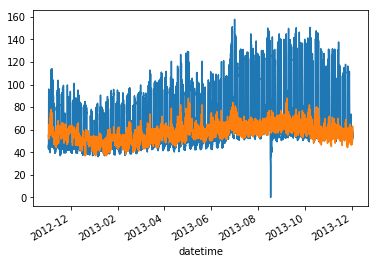

In [6]:
plt.figure(1)
df['power'].plot()
df['temperature'].plot()

In [7]:
def remove_outliers(ts,scale_factor):
    
    mean = np.nanmean(abs(ts))
    ts[abs(ts) > scale_factor*mean] = np.nan
    ts[ts < 39] = np.nan
    return ts

In [8]:
df['power'] = remove_outliers(df['power'].values,5)

In [9]:
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)

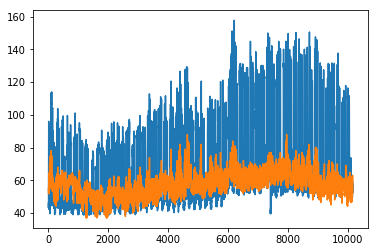

In [10]:
plt.figure(1)
df['power'].plot()
df['temperature'].plot()

Certainly seems to be some separation based on day of week - this is likely to be a good predictor

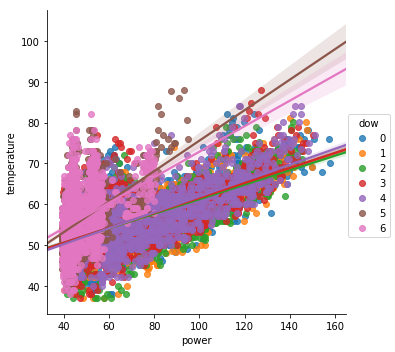

In [11]:
sns.lmplot('power','temperature',data=df,hue='dow')

In [12]:
df.groupby('dow').describe()

month                                                   power  \
      count      mean       std  min  25%  50%    75%   max   count   
dow                                                                   
0    1425.0  6.938947  3.473787  1.0  4.0  7.0  10.00  12.0  1425.0   
1    1425.0  6.790175  3.529994  1.0  4.0  7.0  10.00  12.0  1425.0   
2    1459.0  6.799178  3.509360  1.0  4.0  7.0  10.00  12.0  1459.0   
3    1431.0  6.811321  3.515506  1.0  4.0  7.0  10.00  12.0  1431.0   
4    1474.0  6.991859  3.483830  1.0  4.0  7.0  10.75  12.0  1474.0   
5    1495.0  7.014047  3.538345  1.0  4.0  7.0  11.00  12.0  1495.0   
6    1456.0  7.133242  3.524500  1.0  4.0  7.0  11.00  12.0  1456.0   

                ...                 temperature                             \
          mean  ...      75%    max       count       mean       std   min   
dow             ...                                                          
0    75.876000  ...   94.500  157.8      1425.0  57.087895  7.524125  37.9   
1    75.619158  ...   96.600  150.0      1425.0  56.966175  7.237518  37.0   
2    76.725771  ...   96.600  145.5      1459.0  57.054455  7.149344  37.0   
3    74.569392  ...   93.000  150.3      1431.0  56.870510  7.250838  37.0   
4    75.093826  ...   92.925  151.2      1474.0  57.040988  7.241930  39.9   
5    49.563411  ...   53.700   94.8      1495.0  56.720424  7.138711  39.0   
6    49.180220  ...   53.700   80.4      1456.0  56.960405  6.983289  37.9   

                             
      25%   50%   75%   max  
dow                          
0    51.1  57.0  62.1  82.0  
1    52.0  57.0  62.1  81.0  
2    52.0  57.0  62.1  80.1  
3    52.0  55.9  62.1  88.0  
4    52.0  55.9  61.0  84.0  
5    51.8  55.9  61.0  88.0  
6    52.0  57.0  61.0  82.0  

[7 rows x 24 columns]

In [13]:
df.head()

,datetime,power,temperature,date,time,dow,month
0,2012-11-02 01:00:00-07:00,45.9,55.0,2012-11-02,01:00:00,4,11
1,2012-11-02 02:00:00-07:00,45.3,54.0,2012-11-02,02:00:00,4,11
2,2012-11-02 03:00:00-07:00,43.2,53.1,2012-11-02,03:00:00,4,11
3,2012-11-02 04:00:00-07:00,45.3,52.0,2012-11-02,04:00:00,4,11
4,2012-11-02 05:00:00-07:00,46.2,52.0,2012-11-02,05:00:00,4,11


In [14]:
df['hour_of_day'] = df['time'].apply(lambda x: int(x.split(':')[0]))

In [15]:
df.head()

,datetime,power,temperature,date,time,dow,month,hour_of_day
0,2012-11-02 01:00:00-07:00,45.9,55.0,2012-11-02,01:00:00,4,11,1
1,2012-11-02 02:00:00-07:00,45.3,54.0,2012-11-02,02:00:00,4,11,2
2,2012-11-02 03:00:00-07:00,43.2,53.1,2012-11-02,03:00:00,4,11,3
3,2012-11-02 04:00:00-07:00,45.3,52.0,2012-11-02,04:00:00,4,11,4
4,2012-11-02 05:00:00-07:00,46.2,52.0,2012-11-02,05:00:00,4,11,5


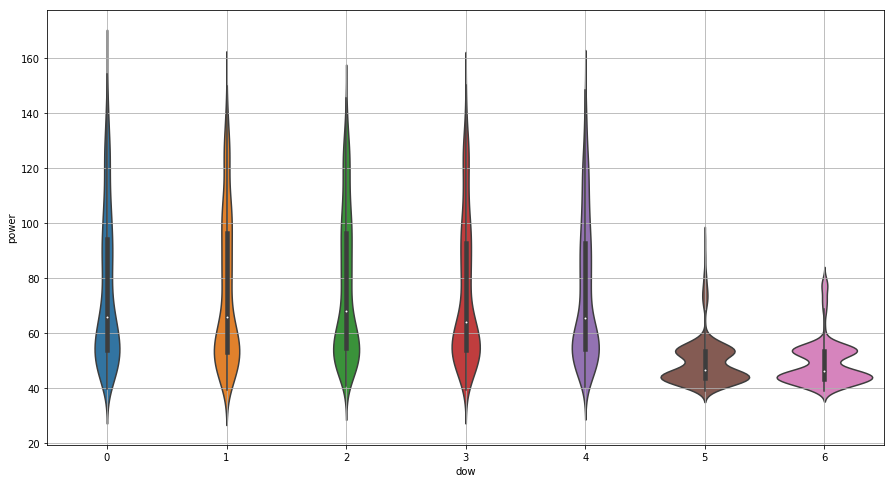

In [16]:
plt.figure(figsize=(15,8))
sns.violinplot(x='dow',y='power',data=df)
plt.grid()

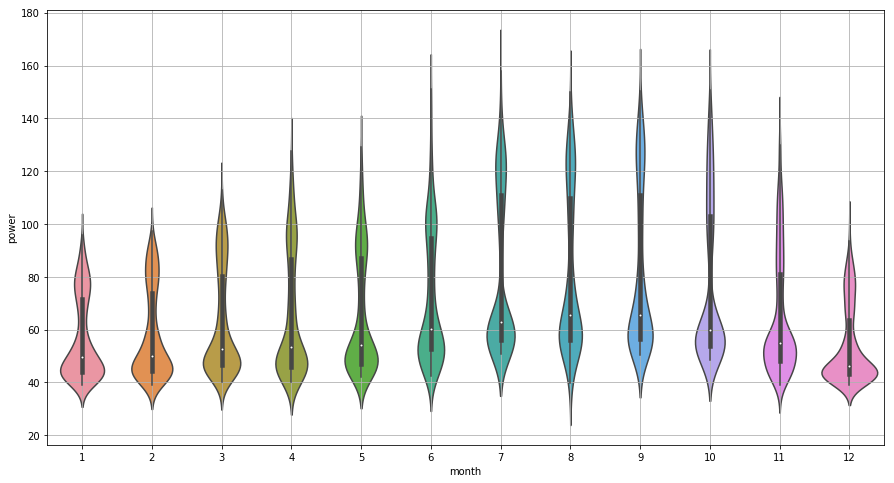

In [17]:
plt.figure(figsize=(15,8))
sns.violinplot(x='month',y='power',data=df)
plt.grid()

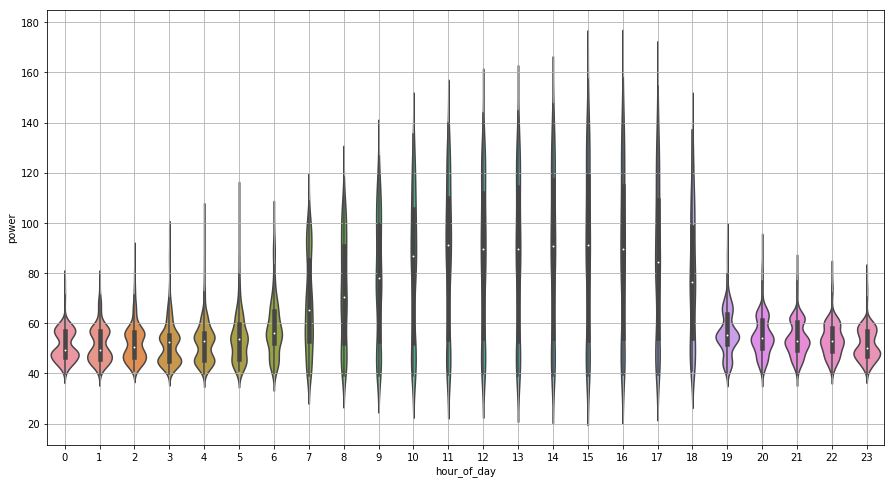

In [18]:
plt.figure(figsize=(15,8))
sns.violinplot(x='hour_of_day',y='power',data=df)
plt.grid()

Its very clear that all three of these features is important in determining the power consumption, so we're going to need to include them in the modelling

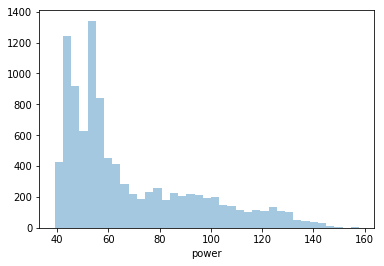

In [19]:
sns.distplot(df['power'],kde=False)

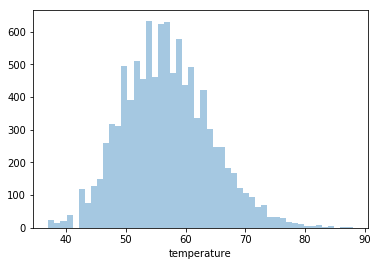

In [20]:
sns.distplot(df['temperature'],kde=False)

## Modelling

#### Lets try a linear regression, a support vector machine and a random forest, to see which looks best. We can also do a search for the optimal hyperparameters

In [21]:
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

/Users/rmartinshort/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [108]:
df.head()

,datetime,power,temperature,date,time,dow,month,hour_of_day
0,2012-11-02 01:00:00-07:00,45.9,55.0,2012-11-02,01:00:00,4,11,1
1,2012-11-02 02:00:00-07:00,45.3,54.0,2012-11-02,02:00:00,4,11,2
2,2012-11-02 03:00:00-07:00,43.2,53.1,2012-11-02,03:00:00,4,11,3
3,2012-11-02 04:00:00-07:00,45.3,52.0,2012-11-02,04:00:00,4,11,4
4,2012-11-02 05:00:00-07:00,46.2,52.0,2012-11-02,05:00:00,4,11,5


In [37]:
def plot_compare_pred_test(pred,test,name):
    true = test
    plt.figure()
    plt.plot(pred,test,'k.')
    plt.plot(true,test,'r')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.grid()
    plt.title(name)

In [117]:
X = df[['temperature','dow','month','hour_of_day']]
y = df['power']

### Test 1: Linear regression

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [119]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

0.41975080236532547


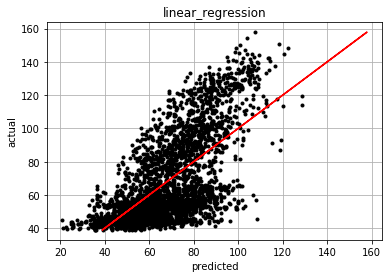

In [122]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_scaled,y_train)
pred = lin_reg.predict(X_test_scaled)
lin_reg_score = lin_reg.score(X_test_scaled,y_test)
print(lin_reg_score)
plot_compare_pred_test(pred,y_test,'linear_regression')

### Test 2: SVM

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [124]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

0.7825334584730158


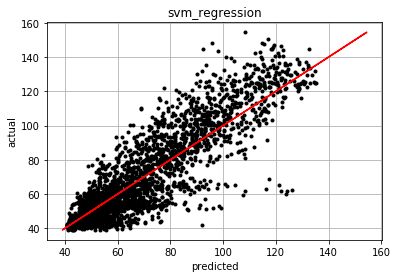

In [125]:
clf = svm.SVR(epsilon=0.01,C=1)
clf.fit(X_train_scaled,y_train)
pred = clf.predict(X_test_scaled)
svm_reg_score = clf.score(X_test_scaled,y_test)
print(svm_reg_score)
plot_compare_pred_test(pred,y_test,'svm_regression')

### Maybe we can do better by running a grid search over parameters - but this is already pretty good

In [32]:
from sklearn.model_selection import GridSearchCV

In [132]:
parameters = {'epsilon':(0.001,0.01,1,10),'C':(0.1,1,10)}
model = svm.SVR()

In [133]:
clf = GridSearchCV(model, parameters)

In [134]:
clf.fit(X_train_scaled,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epsilon': (0.001, 0.01, 1, 10), 'C': (0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
clf.best_score_

0.8166781473582457

### Test 3: Random forest

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

0.9040441792444167


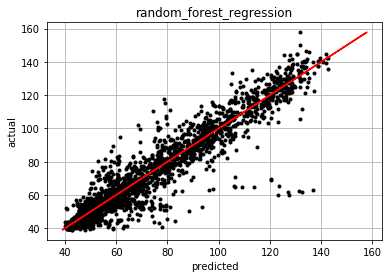

In [147]:
clf = RandomForestRegressor(n_estimators=800,min_samples_leaf=5,min_samples_split=5)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
rf_reg_score = clf.score(X_test,y_test)
print(rf_reg_score)
plot_compare_pred_test(pred,y_test,'random_forest_regression')

In [173]:
parameters = {'n_estimators':(100,500),'min_samples_leaf':(1,3,5,7,10,15,20,50)}
model = RandomForestRegressor()
clf = GridSearchCV(model, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': (100, 500), 'min_samples_leaf': (1, 3, 5, 7, 10, 15, 20, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [175]:
clf.best_score_

0.9122800771637225

In [176]:
model = clf.best_estimator_

#### This is not really good practice, but lets now feed this model a chunk of continuous data and see what it does

In [177]:
test_data = X[-1000:]
test_response = y[-1000:]

In [178]:
len(test_data)

1000

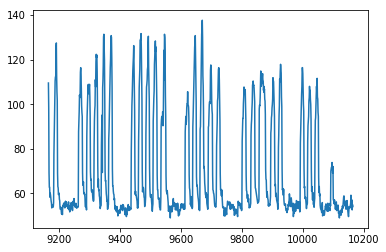

In [179]:
plt.plot(test_response)

In [180]:
test_response_predicted = model.predict(test_data)

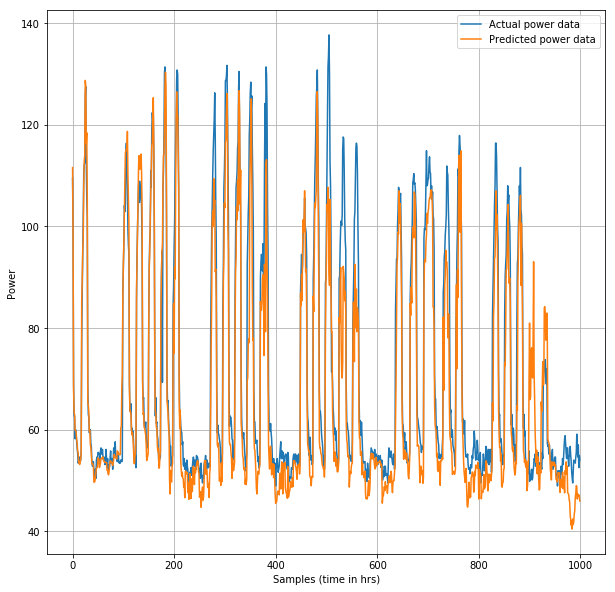

In [208]:
plt.figure(figsize=(10,10))
plt.plot(test_response.values,label='Actual power data')
plt.plot(test_response_predicted,label='Predicted power data')
plt.legend()
plt.xlabel('Samples (time in hrs)')
plt.ylabel('Power')
plt.grid()

In [182]:
model.feature_importances_

array([0.31756292, 0.27344928, 0.06989827, 0.33908952])

This indicates that all features are relatively important. Hour of day actually appears to be more important than temperature

### Maybe a rolling mean over temperature might provide a better predictor

In [204]:
df['rolling_temp'] = df['temperature'].rolling(window=10).mean()
cleaned = df.dropna()
X = cleaned[['rolling_temp','hour_of_day','month','dow']]
y = cleaned['power']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
parameters = {'n_estimators':(100,500),'min_samples_leaf':(1,3,5,7,10,15,20,50)}
model = RandomForestRegressor()
clf = GridSearchCV(model, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': (100, 500), 'min_samples_leaf': (1, 3, 5, 7, 10, 15, 20, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
clf.best_score_

0.9010371000600129

In [207]:
clf.best_params_

{'min_samples_leaf': 3, 'n_estimators': 500}

### This does not appear to have a positive effect

Still, given the faitly limited number of features that we have, the random forest does very well. The fits could likely be improved by adding information about holidays, workers in the office, other weather factors etc.

### Another test - see if knowing about the previous hour's power value helps to predict the current. There will be an issue here because this is correlated with temperature, but we can see what happens

In [22]:
df.head()

,datetime,power,temperature,date,time,dow,month,hour_of_day
0,2012-11-02 01:00:00-07:00,45.9,55.0,2012-11-02,01:00:00,4,11,1
1,2012-11-02 02:00:00-07:00,45.3,54.0,2012-11-02,02:00:00,4,11,2
2,2012-11-02 03:00:00-07:00,43.2,53.1,2012-11-02,03:00:00,4,11,3
3,2012-11-02 04:00:00-07:00,45.3,52.0,2012-11-02,04:00:00,4,11,4
4,2012-11-02 05:00:00-07:00,46.2,52.0,2012-11-02,05:00:00,4,11,5


In [23]:
prev_power = np.full(len(df),np.nan)

In [24]:
for i in range(1,len(df)):
    prev_power[i] = df['power'].values[i-1]

In [25]:
df['prev_power'] = prev_power

In [27]:
df.dropna(inplace=True)

In [28]:
df.reset_index(inplace=True)

In [29]:
X = df[['temperature','dow','month','hour_of_day','prev_power']]
y = df['power']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
parameters = {'n_estimators':(100,500),'min_samples_leaf':(1,3,5,7,10,15,20,50)}
model = RandomForestRegressor()
clf = GridSearchCV(model, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': (100, 500), 'min_samples_leaf': (1, 3, 5, 7, 10, 15, 20, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
clf.best_score_

0.9709540694622568

In [ ]:
model = clf.best_estimator_

In [42]:
model.feature_importances_

array([0.010289  , 0.00630117, 0.00773479, 0.0708016 , 0.90487343])

Note that previous power becomes by far the most important feature here. So much so that the others are essentially useless

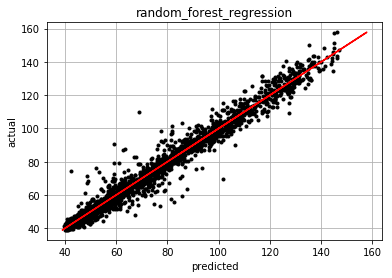

In [43]:
plot_compare_pred_test(model.predict(X_test),y_test,'random_forest_regression')

In [44]:
test_data = X[-1000:]
test_response = y[-1000:]
test_response_predicted = model.predict(test_data)

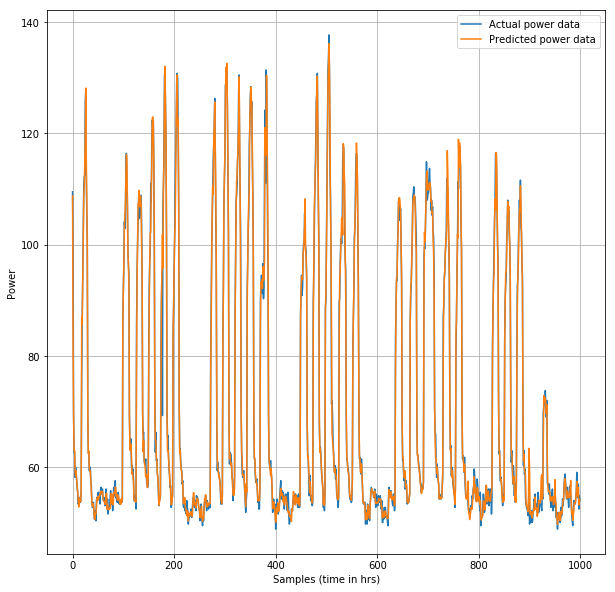

In [45]:
plt.figure(figsize=(10,10))
plt.plot(test_response.values,label='Actual power data')
plt.plot(test_response_predicted,label='Predicted power data')
plt.legend()
plt.xlabel('Samples (time in hrs)')
plt.ylabel('Power')
plt.grid()

This suggests that if we know the previous hour's consumption, we can predict the current consumption very accuratly. In real life though this might not be very reasonable, since we might want to predict many hours in advance. If we only want to predict one hour in advance though, it makes sense to use the data that we have